### Description of the dataset in Matlab

We are using the FIGRIM Fixations Dataset obtained from 
[here](http://figrim.mit.edu/index_eyetracking.html).

More specifically, we are using a subset of 2157 filler images presented once to an average of 15 subjects while recording eye fixation data. The images belong to 21 indoor and outdoor scene categories.

The dataset is available as a .mat-file.

In a first step, the dataset is going to be translated to a pandas dataframe in python.

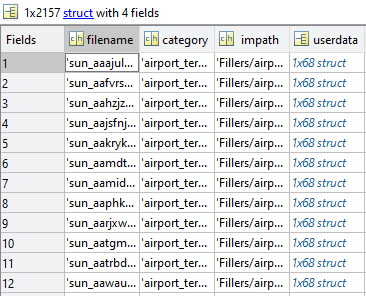

The data is saved in a structure, containing four fields:
-  the filename of the image
-  the category of the image
-  the path to the image
-  another structure labeled "userdata"

So each row of the structure represents the data for one filler image.

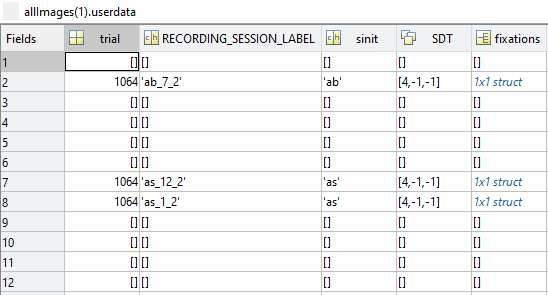

The "userdata"-structure contains data for every subject a picture has been presented to:
- a trial number
- a label for the recording session
- sinit, a field about which we have no further information
- the subjects' response in the continous recognition task: 2 = false alarm, 4 = correct rejection (as these are filler images only presented once, each image should be rejected as it has never been presented before and the second and third entry are missing values)
- fixations: A structure with fields for fixation data for potential 3 presentations of an image (as we only regard fillers, only the field for the first presentation holds data)

### Conversion of Matlab-Structure to Python

#### Preparation of the dataset in Matlab

In order to simplify the data's representation, empty rows in the "userdata"-structure are deleted. Also, the structure stored in the field "fixations" is resolved to this field directly holding the fixation data for a filler image's only presentation. Both of this is done in this [matlab script](files/Matlab/preparation.m).

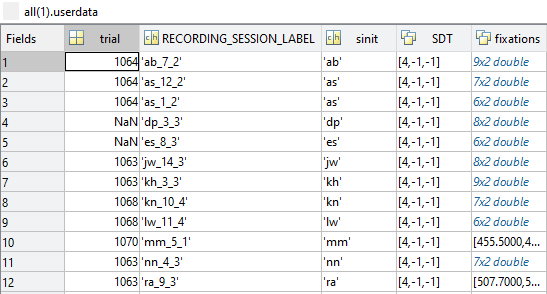

After applying the script, the "userdata"-structure contains no more empty rows and the fixation data for each filler image is directly stored in the field "fixations" as a matrix containing one row for each fixation (ordered sequentially, so that the first row is the first fixation), and one column for the respective x- and y-coordinate of each fixation.

#### Rebuilding the dataset in Python

In [1]:
#loadmat can read .mat-files
from scipy.io import loadmat
import pandas as pd
import imageio
import numpy as np
import pickle

In [2]:
datensatz = loadmat("figrim/fillerData/allImages_edited.mat")

In [3]:
type(datensatz)
for key, value in datensatz.items():
    print(key)

__header__
__version__
__globals__
all


As we can see, the dataset is represented as a dict in python, containing one key "all".

In [4]:
datensatz["all"].shape

(1, 2157)

In [5]:
datensatz["all"][0,0]

(array(['sun_aaajuldidvlcyzhv.jpg'], dtype='<U24'), array(['airport_terminal'], dtype='<U16'), array(['Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg'], dtype='<U49'), array([[(array([[1064]], dtype=uint16), array(['ab_7_2'], dtype='<U6'), array(['ab'], dtype='<U2'), array([[ 4, -1, -1]], dtype=int16), array([[543.3, 476.1],
       [423.5, 453.4],
       [175.1, 856.8],
       [172.2, 947.1],
       [620.3, 600.6],
       [356.3, 336.1],
       [476.5, 351.6],
       [758.9, 586.2],
       [561.7, 408.4]])),
        (array([[1064]], dtype=uint16), array(['as_12_2'], dtype='<U7'), array(['as'], dtype='<U2'), array([[ 4, -1, -1]], dtype=int16), array([[435.5, 464.5],
       [446.5, 492.2],
       [386.1, 472.9],
       [519.5, 537.4],
       [424.4, 584.4],
       [345.7, 467.1],
       [485.6, 511.8]])),
        (array([[1064]], dtype=uint16), array(['as_1_2'], dtype='<U6'), array(['as'], dtype='<U2'), array([[ 4, -1, -1]], dtype=int16), array([[480. , 508.5],
       [486.2, 486.2],


Under this key, the whole dataset is stored as a matrix with one row and 2157 columns, so one column per filler image.

In [6]:
datensatz["all"]["filename"]

array([[array(['sun_aaajuldidvlcyzhv.jpg'], dtype='<U24'),
        array(['sun_aafvrsnoikyyntky.jpg'], dtype='<U24'),
        array(['sun_aahzjzgqsstcdpnq.jpg'], dtype='<U24'), ...,
        array(['sun_agapfnclowtpdpuu.jpg'], dtype='<U24'),
        array(['sun_agesymdojxdbpgfs.jpg'], dtype='<U24'),
        array(['sun_agxnmwetdgazrgba.jpg'], dtype='<U24')]], dtype=object)

The fields from the .mat-file can still be adressed.

In [7]:
datensatz["all"][0,0][3][0,0][4]
datensatz["all"]["userdata"][0,0][0,0][4]

array([[543.3, 476.1],
       [423.5, 453.4],
       [175.1, 856.8],
       [172.2, 947.1],
       [620.3, 600.6],
       [356.3, 336.1],
       [476.5, 351.6],
       [758.9, 586.2],
       [561.7, 408.4]])

In total, the (1, 2157)-matrix holds in each column an array (or rather a vector)  containing all data for one image. The elements of this array are themselves arrays, or in the case of the "userdata", nested arrays. Single elements can be adressed by selecting a column (corresponding to a row in the matlab-structure) of the (1,2157)-array and then an element of this column, which again can have elements on its own. To get to the fixation data of the first subject for the first image, we select the first column of the (1,2157)-array. From this column, we select the fourth entry (or the entry labeled "userdata"). "userdata" itself is an array with one row and one column per subject, so we select the first column from this array and then the fifth element from this column, corresponding to the fixation data.   

To rebuild the dataset in a way that resembles the matlab-structure and allows easy indexing/assessing of the data, we will build a pandas dataframe containing the columns
- filenmame
- category
- impath
- userdata

and one row per image, just like in the matlab-structure.

The column "userdata" contains further dataframes, containing the columns
- trial
- recording session
- sinit
- SDT
- fixations

thus storing all information about each subject that has been presented an image.


In [8]:
#recreate filename, category and impath, each as list
filename = []
category = []
impath = []

lists = [filename, category, impath]
for h in range(0,len(lists)):
    #for each column (for each image)
    for i in range(datensatz["all"].size):
        #extract the filename, category and impath
        lists[h].append(datensatz["all"][0,i][h][0])

In [9]:
#recreate userdata as list of dataframes
userdata = []

#for each column (for each image)
for h in range(0,datensatz["all"].size):
    trial = []
    #iterate through every subject in "userdata"
    for i in range(0,datensatz["all"][0,h][3].size):
        #and extract the trial-number
        trial.append(datensatz["all"][0,h][3][0,i][0][0,0])
    len(trial)

    recording_session = []
    for i in range(0,datensatz["all"][0,h][3].size):
        recording_session.append(datensatz["all"][0,h][3][0,i][1][0])
    len(recording_session)

    sinit = []
    for i in range(0,datensatz["all"][0,h][3].size):
        sinit.append(datensatz["all"][0,h][3][0,i][2][0])
    len(sinit)

    sdt = []
    for i in range(0,datensatz["all"][0,h][3].size):
        sdt.append(datensatz["all"][0,h][3][0,i][3])
    sdt

    fixations = []
    for i in range(0,datensatz["all"][0,h][3].size):
        fixations.append(datensatz["all"][0,h][3][0,i][4])
    fixations[0].shape

    #for each column (each image), put all lists together as a df and append it to the list of dfs
    daten = {"trial":trial, "recording_session_label":recording_session, "sinit":sinit, "SDT":sdt, "fixations":fixations}
    df = pd.DataFrame(data=daten, columns = ["trial", "recording_session_label", "sinit", "SDT", "fixations"])
    userdata.append(df)

In [10]:
#put everything into one dataframe containing filename, category, impath and userdata
daten = {"filename":filename, "category":category, "impath":impath, "userdata":userdata}
allImages = pd.DataFrame(data=daten, columns = ["filename", "category", "impath", "userdata"])
allImages
allImages.loc[0,"userdata"]

,trial,recording_session_label,sinit,SDT,fixations
0,1064.0,ab_7_2,ab,"[[4, -1, -1]]","[[543.3, 476.1], [423.5, 453.4], [175.10000000..."
1,1064.0,as_12_2,as,"[[4, -1, -1]]","[[435.5, 464.5], [446.5, 492.2], [386.1, 472.9..."
2,1064.0,as_1_2,as,"[[4, -1, -1]]","[[480.0, 508.5], [486.20000000000005, 486.2], ..."
3,NaN,dp_3_3,dp,"[[4, -1, -1]]","[[492.70000000000005, 504.1], [377.70000000000..."
4,NaN,es_8_3,es,"[[4, -1, -1]]","[[491.4, 540.4], [344.8, 431.7], [286.3, 358.1..."
5,1063.0,jw_14_3,jw,"[[4, -1, -1]]","[[458.70000000000005, 374.3], [470.1, 403.4], ..."
6,1063.0,kh_3_3,kh,"[[4, -1, -1]]","[[502.79999999999995, 466.1], [473.70000000000..."
7,1068.0,kn_10_4,kn,"[[4, -1, -1]]","[[547.8, 503.79999999999995], [421.70000000000..."
8,1068.0,lw_11_4,lw,"[[4, -1, -1]]","[[516.9, 532.8], [391.0, 725.0], [488.0, 591.1..."
9,1070.0,mm_5_1,mm,"[[4, -1, -1]]","[[455.5, 443.5], [209.10000000000002, 720.5], ..."


##### Unfolding

In order to obtain a two-dimensional dataframe, now every subject per image is treated as one case (one row).

In [11]:
#Copy df
allImages_unfolded = allImages.copy()

In [12]:
#add filename, category and impath to each userdata-df
new_cols = ["filename", "category", "impath"]
for i in range(0,len(allImages_unfolded)):
    for j in range(0,len(new_cols)):
        for k in range(0,len(allImages_unfolded.loc[i,"userdata"])):
            allImages_unfolded.loc[i,"userdata"].loc[k,new_cols[j]] = allImages_unfolded.loc[i,new_cols[j]]

In [13]:
#concatenate all userdata-dfs together
frames = []
for i in range(0,len(allImages_unfolded)):
    frames.append(allImages_unfolded.loc[i,"userdata"])
allImages_unfolded_total = pd.concat(frames, ignore_index=True)
allImages_unfolded = allImages_unfolded_total

In [14]:
#change column order
allImages_unfolded = allImages_unfolded[["filename", "category", "impath", "trial", "recording_session_label", "sinit", "SDT", "fixations"]]

In [15]:
#result: two-dimensional df
allImages_unfolded

,filename,category,impath,trial,recording_session_label,sinit,SDT,fixations
0,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,1064.0,ab_7_2,ab,"[[4, -1, -1]]","[[543.3, 476.1], [423.5, 453.4], [175.10000000..."
1,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,1064.0,as_12_2,as,"[[4, -1, -1]]","[[435.5, 464.5], [446.5, 492.2], [386.1, 472.9..."
2,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,1064.0,as_1_2,as,"[[4, -1, -1]]","[[480.0, 508.5], [486.20000000000005, 486.2], ..."
3,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,NaN,dp_3_3,dp,"[[4, -1, -1]]","[[492.70000000000005, 504.1], [377.70000000000..."
4,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,NaN,es_8_3,es,"[[4, -1, -1]]","[[491.4, 540.4], [344.8, 431.7], [286.3, 358.1..."
5,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,1063.0,jw_14_3,jw,"[[4, -1, -1]]","[[458.70000000000005, 374.3], [470.1, 403.4], ..."
6,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,1063.0,kh_3_3,kh,"[[4, -1, -1]]","[[502.79999999999995, 466.1], [473.70000000000..."
7,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,1068.0,kn_10_4,kn,"[[4, -1, -1]]","[[547.8, 503.79999999999995], [421.70000000000..."
8,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,1068.0,lw_11_4,lw,"[[4, -1, -1]]","[[516.9, 532.8], [391.0, 725.0], [488.0, 591.1..."
9,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,1070.0,mm_5_1,mm,"[[4, -1, -1]]","[[455.5, 443.5], [209.10000000000002, 720.5], ..."


This can now be stored in a .json-file

In [16]:
#orient="split" stores index and column information in lists, to keep the order of the df
allImages_unfolded.to_json("allImages_unfolded.json", orient="split")

In [18]:
#use orient="split" on reading as well
allImages_unfolded = pd.read_json("allImages_unfolded.json", orient="split")
allImages_unfolded

,filename,category,impath,trial,recording_session_label,sinit,SDT,fixations
0,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,1064.0,ab_7_2,ab,"[[4, -1, -1]]","[[543.3, 476.1], [423.5, 453.4], [175.1, 856.8..."
1,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,1064.0,as_12_2,as,"[[4, -1, -1]]","[[435.5, 464.5], [446.5, 492.2], [386.1, 472.9..."
2,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,1064.0,as_1_2,as,"[[4, -1, -1]]","[[480.0, 508.5], [486.2, 486.2], [543.4, 591.0..."
3,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,NaN,dp_3_3,dp,"[[4, -1, -1]]","[[492.7, 504.1], [377.7, 566.5], [304.6, 482.1..."
4,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,NaN,es_8_3,es,"[[4, -1, -1]]","[[491.4, 540.4], [344.8, 431.7], [286.3, 358.1..."
5,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,1063.0,jw_14_3,jw,"[[4, -1, -1]]","[[458.7, 374.3], [470.1, 403.4], [556.6, 560.5..."
6,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,1063.0,kh_3_3,kh,"[[4, -1, -1]]","[[502.8, 466.1], [473.7, 425.0], [497.5, 619.7..."
7,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,1068.0,kn_10_4,kn,"[[4, -1, -1]]","[[547.8, 503.8], [421.7, 673.7], [189.5, 870.3..."
8,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,1068.0,lw_11_4,lw,"[[4, -1, -1]]","[[516.9, 532.8], [391.0, 725.0], [488.0, 591.1..."
9,sun_aaajuldidvlcyzhv.jpg,airport_terminal,Fillers/airport_terminal/sun_aaajuldidvlcyzhv.jpg,1070.0,mm_5_1,mm,"[[4, -1, -1]]","[[455.5, 443.5], [209.1, 720.5], [557.3, 486.3]]"


**Result**
<br>
`allimages_unfolded.json` containing an unfolded version of the previous Matlab-Structure.
<br>
This contains `{{len(allImages_unfolded)}}` cases. Each case is an image and fixation data for this image from one subject. An average of 15 subjects viewed each image.

